## Sentiment classification of 100 forum posts by human and 3 open-source models

In this notebook, 100 randomly selected forum posts are evaluated regarding their sentiment (positive, neutral, negative) using three different open-source models and annotations by a human serving as ground truth. The ojective was to compare the performance of each model, analyize their erros and in conclusion identify the best performing model.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import yaml
with open ("/content/drive/MyDrive/github_projects/fine_tuning_ai_for_sentiments/config/config.yaml", "r") as f:
  config = yaml.safe_load(f)

### Loading the forum posts

In [ ]:
# load the csv file containing all forum posts extract a test set of 100 random forum posts and save them as well as the residual forum posts into separate files
# important: in the code no random_state was used in the sampling step which means each time the code is run a different sample set will be selected.
# Therefore if you want to continue this project to avoid having a different sample, load the previously saved files with the code in the next cell,
# if you want to use the code on a different dataset be sure to add a random_state as e.g. "3" to ensure reproducibility.

# warning: if you still run the following cells, you might overwrite the provided files with the defined sample
# df_forum_posts_all_initial = pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_all_initial.csv")
# df_forum_posts_100_test = df_forum_posts_all_initial.sample(n=100, random_state=None)
# display(df_forum_posts_100_test)
# df_forum_posts_100_test.to_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test.csv", index=False)
# forum_posts_without_100_test = df_forum_posts_all_initial[~df_forum_posts_all_initial["ID"].isin(df_forum_posts_100_test["ID"])]
# display(forum_posts_without_100_test)
# forum_posts_without_100_test.to_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_without_100_test.csv", index=False)

In [ ]:
# loading the forum posts from previously saved files
df_forum_posts_100_test = pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test.csv")
display(df_forum_posts_100_test)
forum_posts_without_100_test = pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_without_100_test.csv")
forum_posts_without_100_test

,ID,text,datetime,company
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate
...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla


,ID,text,datetime,company
0,43,Man spürt wie jemand den Kurs gierig künst...,2021-07-07 13:05:40,1_und_1_Drillisch
1,214,Wovon sollte das bezahlt werden? Die Divid...,2020-08-29 08:20:13,1_und_1_Drillisch
2,330,">>Wer genau hinschaut, erkennt die Sinnlosigk...",2019-06-19 18:04:05,1_und_1_Drillisch
3,429,Der Markt dürfte für Drillisch enger durch di...,2018-10-28 20:27:34,1_und_1_Drillisch
4,607,27.10.15 13:12 aktiencheck.de Maintal (www.a...,2015-11-02 10:04:41,1_und_1_Drillisch
...,...,...,...,...
86078,1440349,"naja aber was wäre : stoppkurse bei 7,75€ (al...",2008-07-02 12:29:21,Wirecard
86079,1440354,"hübsches sümmchen, was da investiert wurde...",2008-07-02 11:56:10,Wirecard
86080,1440381,SES macht bewusst den Kurs kaput. Das ist ...,2008-07-01 16:00:48,Wirecard
86081,1440414,9 EUR ...... wir kommen,2008-07-01 09:09:33,Wirecard


###Sentiment classification using oliverguhr "german-sentiment-bert"
source: https://huggingface.co/oliverguhr/german-sentiment-bert

Description from huggingface: This model was trained for sentiment classification of German language texts. To achieve the best results all model inputs needs to be preprocessed with the same procedure, that was applied during the training. To simplify the usage of the model, we provide a Python package that bundles the code need for the preprocessing and inferencing. </br>
The model uses the Googles Bert architecture and was trained on 1.834 million German-language samples. The training data contains texts from various domains like Twitter, Facebook and movie, app and hotel reviews.

In [ ]:
# installing the model
!pip install germansentiment -q

In [ ]:
# importing the SentimentModel
from germansentiment import SentimentModel

# initializing the model
model = SentimentModel()

# a list of example texts which are provided with the model to illustrate how it works.
texts = [
    "Mit keinem guten Ergebniss","Das ist gar nicht mal so gut",
    "Total awesome!","nicht so schlecht wie erwartet",
    "Der Test verlief positiv.","Sie fährt ein grünes Auto."]

# predicting the sentiments
result = model.predict_sentiment(texts)
result

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


['negative', 'negative', 'positive', 'positive', 'neutral', 'neutral']

In [ ]:
# in cases where one would want to see the probabilites for each class the following code could be used

# classes, probabilities = model.predict_sentiment(["das ist super"], output_probabilities = True)
# print(classes, probabilities)

In [ ]:
# sentiment classification of the selected 100 forums posts
df_forum_posts_100_test["sentiment_oliverguhr"] = model.predict_sentiment(df_forum_posts_100_test["text"])
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral
...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative


###Sentiment classification using bardsai "finance-sentiment-de-base"
source: https://huggingface.co/bardsai/finance-sentiment-de-base

Description from huggingface: Finance Sentiment DE (base) is a model based on bert-base-german-cased for analyzing sentiment of German financial news. It was trained on the translated version of Financial PhraseBank by Malo et al. (20014) for 10 epochs on single RTX3090 gpu. The model will give you a three labels: positive, negative and neutral.

In [ ]:
# importing the pipeline() function from the transformers library to load the model directly from huggingface
from transformers import pipeline
nlp = pipeline("sentiment-analysis", model="bardsai/finance-sentiment-de-base")

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/727k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# an example text which is provided with the model to illustrate how it works
display(nlp("Der Nettoumsatz stieg um 30 % auf 36 Mio. EUR."))
# extracting the sentiment classification
nlp("Der Nettoumsatz stieg um 30 % auf 36 Mio. EUR.")[0]["label"]

[{'label': 'positive', 'score': 0.9999468326568604}]

'positive'

In [ ]:
# sentiment classification of the selected 100 forums posts
# feeding the text as a list
sentiment_classification_raw = nlp(df_forum_posts_100_test["text"].to_list())
# extracting the sentiments as a list using list comprehension
sentiment_classification_clean = [sentiment["label"] for sentiment in sentiment_classification_raw]
df_forum_posts_100_test["sentiment_bardsai"] = sentiment_classification_clean
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral
...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral


###Sentiment classification using lxyuan "distilbert-base-multilingual-cased-sentiments-student"
source: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

Description: The model is a distilled version of a zero-shot classification model trained on a multilingual sentiment dataset. While the dataset was actually annotated, for this training zero-shot learning was simluated.</br>
- teacher model: MoritzLaurer/mDeBERTa-v3-base-mnli-xnli
- teacher hypothesis template: "The sentiment of this text is {}."
- Student model: distilbert-base-multilingual-cased

In [ ]:
# importing the pipeline() function from the transformers library to load the model directly from huggingface
from transformers import pipeline
distilled_student_sentiment_classifier = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", truncation = True, max_length = 512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# verification that the model works

texts = [
    "Das war ein wirklich schöner Tag",
    "Der Tag heute war neutral",
    "Heute war ein wirklich ganz schlechter Tag"]

result = distilled_student_sentiment_classifier(texts)  # predicting the sentiments
result


[{'label': 'positive', 'score': 0.9597814679145813},
 {'label': 'neutral', 'score': 0.4247487783432007},
 {'label': 'negative', 'score': 0.9576665163040161}]

In [ ]:
# sentiment classification of the selected 100 forums posts
# feeding the text as a list
sentiment_classification_raw = distilled_student_sentiment_classifier(df_forum_posts_100_test["text"].to_list())
# extracting the sentiments as a list using list comprehension
sentiment_classification_clean = [sentiment["label"] for sentiment in sentiment_classification_raw]
df_forum_posts_100_test["sentiment_lxyuan"] = sentiment_classification_clean
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral,positive
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral,negative
...,...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive,negative
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral,negative
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral,negative


###Manual sentiment classification by human

In [ ]:
# loading the manual sentiment classification done by a human
df_forum_posts_100_test_classification_by_human =  pd.read_csv(config["project_path"]+config["data_raw_dir"]+"forum_posts_100_test_classification_by_human.csv")
df_forum_posts_100_test_classification_by_human

,ID,text,datetime,company,classification_by_human
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral
...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,neutral
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative


In [ ]:
# adding the column with the classifications done by human to the other three sentiment classifications done by the open-source models
df_forum_posts_100_test = df_forum_posts_100_test.merge(df_forum_posts_100_test_classification_by_human[["ID", "classification_by_human"]], on = "ID")
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan,classification_by_human
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive,negative
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral,positive,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral,negative,neutral
...,...,...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive,negative,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral,negative,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral,negative,neutral
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral,negative,negative


In [ ]:
# saving the results of the classifications done by human to the other sentiment classification by the three evaluated open-source models into one CSV file
# df_forum_posts_100_test.to_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test_classification_by_human_and_3_open_source_models.csv", index = False, encoding = "utf-8")

##Evaluating the performance of the different models

Evaluating the performance of the different models with the objective to identify the best performing model.

### Classification reports and confusion matrices

In [ ]:
df_forum_posts_100_test =  pd.read_csv(config["project_path"]+config["data_processed_dir"]+"forum_posts_100_test_classification_by_human_and_3_open_source_models.csv")
df_forum_posts_100_test

,ID,text,datetime,company,sentiment_oliverguhr,sentiment_bardsai,sentiment_lxyuan,classification_by_human
0,741247,"Lass das nicht Deine Perle lesen, sonst musst...",2010-03-31 10:16:04,Infineon_Technologies,negative,neutral,negative,negative
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,neutral,negative,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,negative,neutral,positive,negative
3,914213,godmode-trader.de,2013-02-22 16:11:14,LPKF_Laser_und_Electronics,positive,neutral,positive,neutral
4,36252,"Das gilt nur für die Adler Group SA, oder auch...",2022-12-09 09:51:20,ADLER_Real_Estate,neutral,neutral,negative,neutral
...,...,...,...,...,...,...,...,...
95,1401875,Bin ja auch sehr optimistisch gestimmt. ...,2019-03-16 19:43:12,Wirecard,positive,positive,negative,positive
96,1243426,heute sieht es so aus als würde die Unterstütz...,2018-09-04 13:44:38,Volkswagen,neutral,neutral,negative,negative
97,1114627,"Wieder keine Vola, obwohl der Gesamtmarkt neu...",2020-08-26 09:17:15,Secunet_Security_Networks,negative,neutral,negative,neutral
98,1060385,du wirst es nie lernen ! substanz sieht an...,2006-10-17 17:37:43,PVA_TePla,negative,neutral,negative,negative


In [ ]:
# generating classification reports
y_true = df_forum_posts_100_test["classification_by_human"]
column_names_model_predictions = ["sentiment_oliverguhr", "sentiment_bardsai", "sentiment_lxyuan"]

for column_model_prediction in column_names_model_predictions:
  y_pred = df_forum_posts_100_test[column_model_prediction]
  print(f"The classification report for using {column_model_prediction} for the forum_posts_100_test is: \n")
  print(classification_report(y_true, y_pred), "\n")

The classification report for using sentiment_oliverguhr for the forum_posts_100_test is: 

              precision    recall  f1-score   support

    negative       0.43      0.56      0.49        34
     neutral       0.50      0.51      0.51        45
    positive       0.40      0.19      0.26        21

    accuracy                           0.46       100
   macro avg       0.44      0.42      0.42       100
weighted avg       0.46      0.46      0.45       100
 

The classification report for using sentiment_bardsai for the forum_posts_100_test is: 

              precision    recall  f1-score   support

    negative       0.55      0.18      0.27        34
     neutral       0.51      0.84      0.64        45
    positive       0.60      0.43      0.50        21

    accuracy                           0.53       100
   macro avg       0.55      0.48      0.47       100
weighted avg       0.54      0.53      0.48       100
 

The classification report for using sentiment_lxyuan 

The confusion matrix for using sentiment_oliverguhr for the forum_posts_100_test:


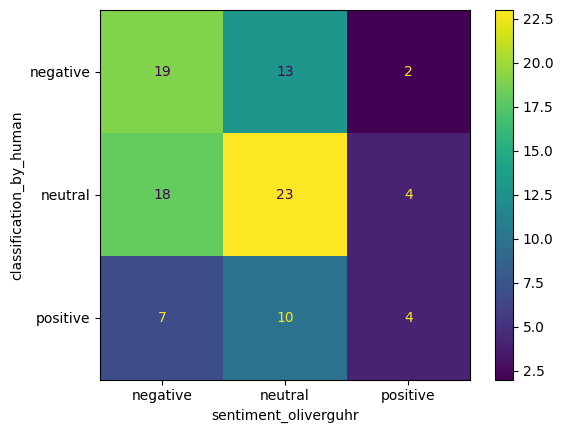



The confusion matrix for using sentiment_bardsai for the forum_posts_100_test:


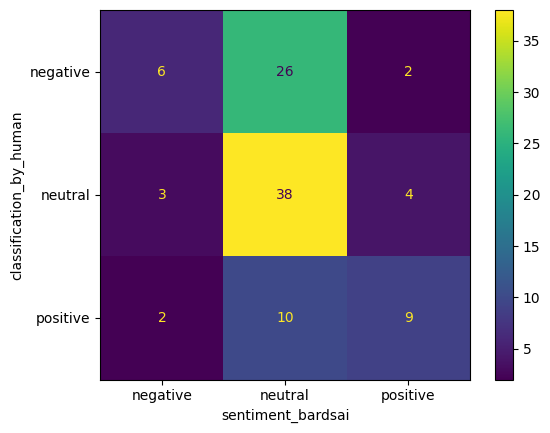



The confusion matrix for using sentiment_lxyuan for the forum_posts_100_test:


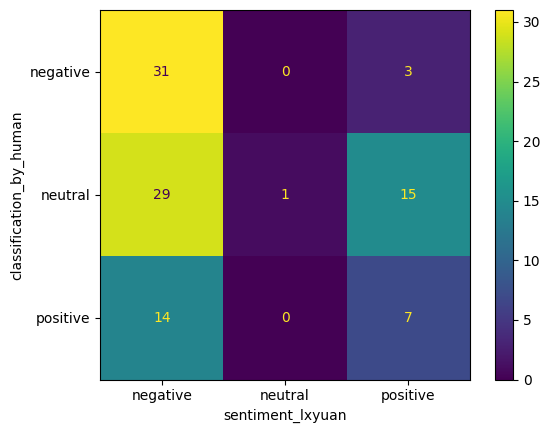

In [ ]:
# generating confusion matrices
y_true = df_forum_posts_100_test["classification_by_human"]

for column_model_prediction in column_names_model_predictions:
  y_pred = df_forum_posts_100_test[column_model_prediction]
  print(f"The confusion matrix for using {column_model_prediction} for the forum_posts_100_test:")
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  plt.xlabel(column_model_prediction)
  plt.ylabel("classification_by_human")
  plt.show()
  print("\n")

### Detailed analysis of forum posts that were classified exactely the opposite

In [ ]:
# if you want to have a closer look at which forum posts were judged opposite ways (negative - positive, positive - negative) you can use the following code to isolate those posts and analyize them

model_1 = "classification_by_human"
model_2 = "sentiment_lxyuan"         #select from the following ["sentiment_oliverguhr", "sentiment_bardsai", "sentiment_lxyuan"]

cond_1 = ((df_forum_posts_100_test[model_1] == "negative") &  (df_forum_posts_100_test[model_2] == "positive"))
cond_2 = ((df_forum_posts_100_test[model_1] == "positive") &  (df_forum_posts_100_test[model_2] == "negative"))

df_forum_posts_100_test_judged_opposite = df_forum_posts_100_test[cond_1 | cond_2]

display(df_forum_posts_100_test_judged_opposite[["ID", "text", "datetime", "company", model_2, model_1]])

,ID,text,datetime,company,sentiment_lxyuan,classification_by_human
1,1392918,"Wirecard ist zu unrecht abgestraft, ich finde...",2019-05-04 14:25:17,Wirecard,negative,positive
2,917829,"jo und den chart anschauen, nie am höchepunkt...",2022-10-24 20:48:08,LPKF_Laser_und_Electronics,positive,negative
5,136997,BMW will in den nächsten Jahren deutlich m...,2014-12-02 10:15:09,BMW,negative,positive
10,761767,"immer wieder das gleiche SPiel, zuviel zit...",2009-10-16 16:23:27,Infineon_Technologies,negative,positive
13,1404457,Durch den Kurssturz angelockt bin ich mitt...,2019-02-25 21:20:10,Wirecard,negative,positive
28,766515,"Lasst mal die Grossen kommen,dann beissen sic...",2009-08-28 14:47:35,Infineon_Technologies,negative,positive
29,631183,Den Gedanken zur globalen Definition des Mark...,2009-10-30 09:22:06,Freenet,negative,positive
35,1057016,haddu recht..,2008-05-06 22:19:06,PVA_TePla,negative,positive
41,342166,... Aufgeschreckt vom Erfolg des StreetScoote...,2017-11-23 12:29:36,Daimler,negative,positive
53,747560,Aber IFX gefällt mir auch wieder heute,2010-01-25 10:11:25,Infineon_Technologies,negative,positive
